Monthly Beer Production

Problem Statement: Build a model to forecast of Beer Production

Using only the following data (https://www.kaggle.com/sergiomora823/monthly-beer-production), please provide a forecast of monthly Australian beer production for the year 1996..

The main areas covered are:

Overview of the data

Exploratory data analysis

SARIMA model

SARIMAX model

Prophet model

Comparision of models

Summary

1. Data Ingesiton

2. Eda of the data

3. processing of the data

4. model building

5. model evalution

# Data Ingestion

Import the Required Libraries: Import the required libraries such as pandas, numpy, matplotlib, seaborn, etc.

Load the Data.

Load the Time Series Data into a pandas dataframe.

Check the datatype of the index and convert it to datetime if necessary.

Set the datetime column as the index of the dataframe.



In [1]:
import warnings
warnings.filterwarnings('ignore')

In [68]:
import pandas as pd
data=pd.read_csv(r"D:\projects\data\timeseries\monthly-beer-production-in-austr.csv")

In [69]:
data.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [70]:
data.tail()

,Month,Monthly beer production
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0
475,1995-08,153.0


In [71]:
data.shape

(476, 2)

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [74]:
data["Month"]=pd.to_datetime(data["Month"])

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    476 non-null    datetime64[ns]
 1   Monthly beer production  476 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.6 KB


In [76]:
data.isnull().sum()

Month                      0
Monthly beer production    0
dtype: int64

In [78]:
data=data.set_index("Month")

In [79]:
data

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0


# why we are converting date column as a index column

1. i can easily retrive the data
2. visulization is also simple
3. those lib has been degine in such a way it required date column as a index(scipy statsmodel)

# EDA(exploratory data analysis)

1. Summary Statistics
- Compute summary statistics such as mean, median, mode, standard deviation, to get an overview of the data.

2. Visualize the Time Series Data
- Plot the Time Series data 

- Plot the rolling mean and rolling standard deviation of the Time Series data.
- Decompose the Time Series Data check for any trends, seasonality, and Noise.
- Plot the decomposed components to get a better understanding of the Time Series data.

3. Stationarity Check
- Check for stationarity.
- Check for stationarity of the Time Series data using the Augmented Dickey-Fuller test.

4. Check for Autocorrelation
- Plot the autocorrelation function (ACF) and partial autocorrelation function (PACF) to identify the order of the ARIMA model.

5. Outlier Detection
- Detect and handle outliers using statistical methods or machine learning techniques.

In [80]:
data.describe()

,Monthly beer production
count,476.000000
mean,136.395378
std,33.738725
min,64.800000
25%,112.900000
50%,139.150000
75%,158.825000
max,217.800000


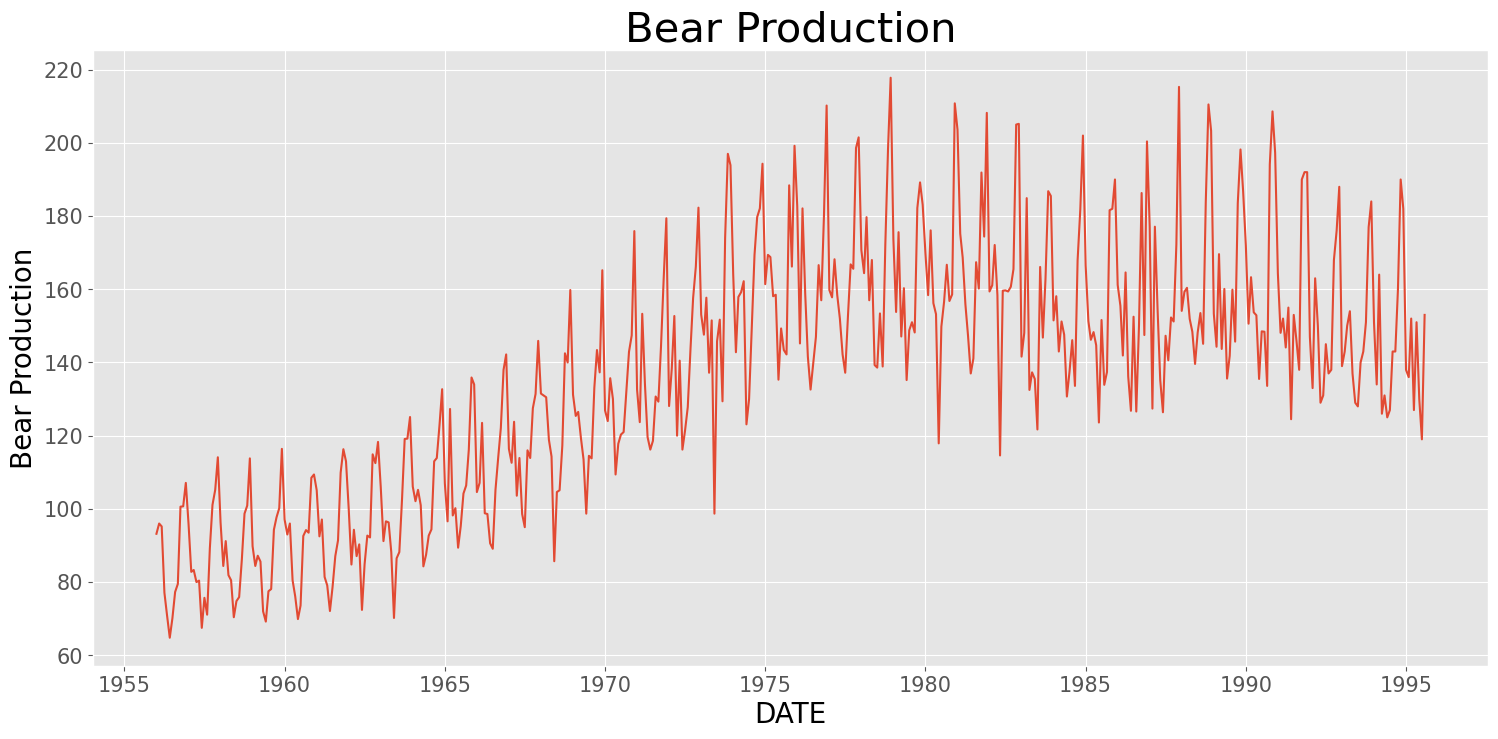

In [82]:
plt.style.use('ggplot')
plt.figure(figsize=(18,8))
plt.grid(True)
plt.xlabel("DATE",fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel("Bear Production",fontsize=20)
plt.yticks(fontsize = 15) 
plt.plot(data["Monthly beer production"])
plt.title("Bear Production",fontsize=30)
plt.show()

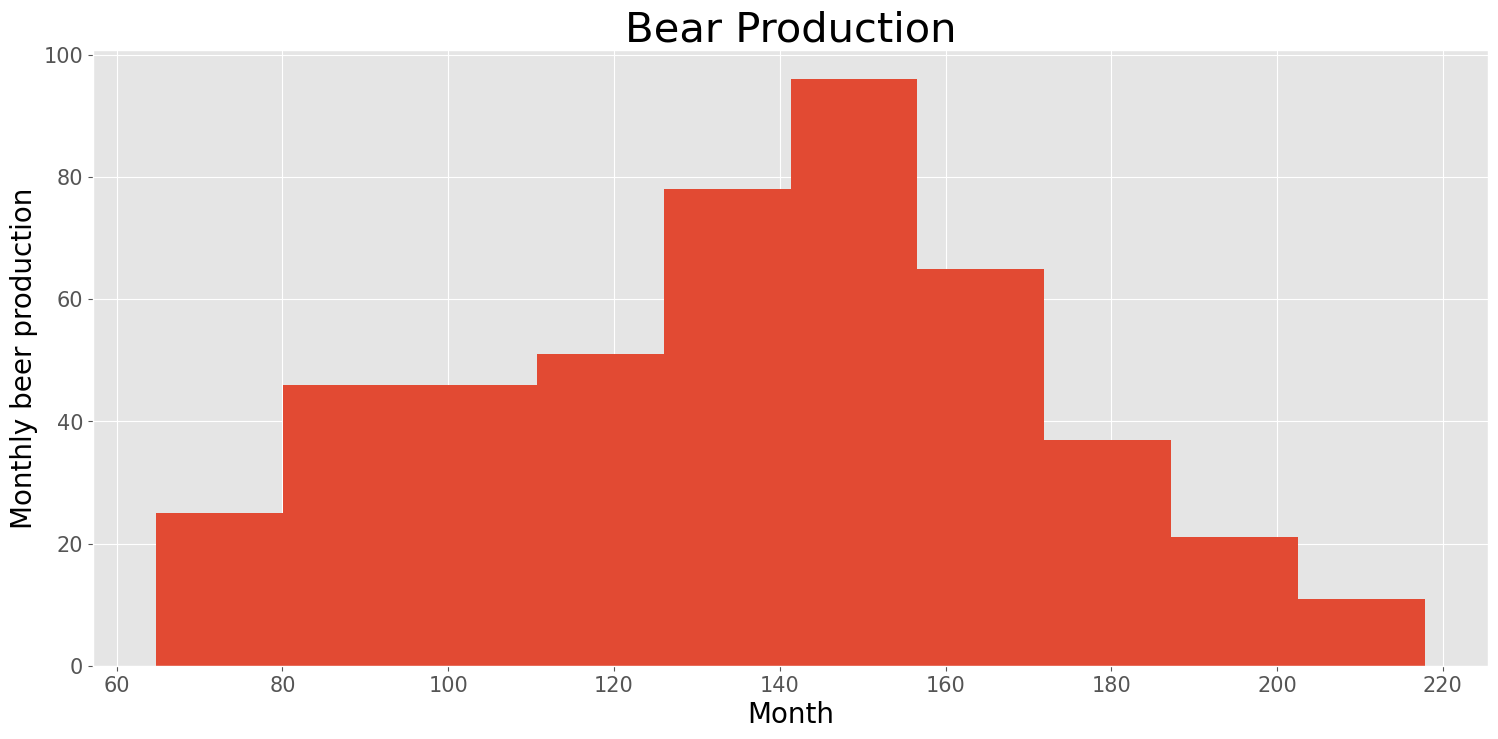

In [83]:
plt.style.use('ggplot')
plt.figure(figsize=(18,8))
plt.grid(True)
plt.xlabel("Month",fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel("Monthly beer production",fontsize=20)
plt.yticks(fontsize = 15) 
plt.hist(data["Monthly beer production"])
plt.title("Bear Production",fontsize=30)
plt.show()

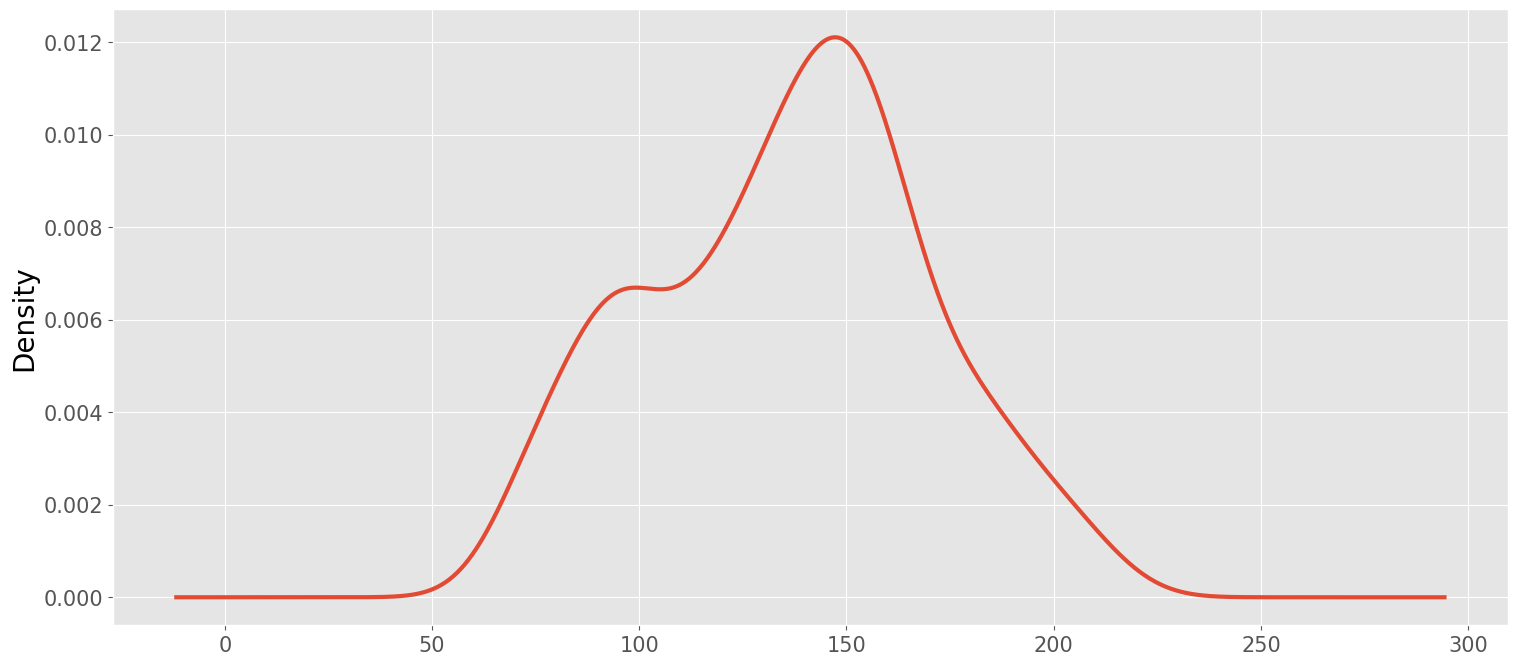

In [86]:
df_beer_production = data["Monthly beer production"] 
df_beer_production.plot(kind='kde',figsize = (18,8), linewidth= 3) 
plt.xticks(fontsize = 15)
plt.grid("both")
plt.ylabel('Density', fontsize = 20)
plt.yticks(fontsize = 15)
plt.show()

In [18]:
## adfuller is telling the data is stationary or non-stationary
from statsmodels.tsa.stattools import adfuller

In [87]:
#Test for staionarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(48).mean() # rolling mean
    rolstd = timeseries.rolling(48).std() # rolling standard deviation
    # Plot rolling statistics:
    plt.figure(figsize = (18,8))
    plt.grid('both')
    plt.plot(timeseries, color='blue',label='Original', linewidth = 3)
    plt.plot(rolmean, color='red', label='Rolling Mean',linewidth = 3)
    plt.plot(rolstd, color='black', label = 'Rolling Std',linewidth = 4)
    plt.legend(loc='best', fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
    plt.title('Rolling Mean and Standard Deviation', fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    

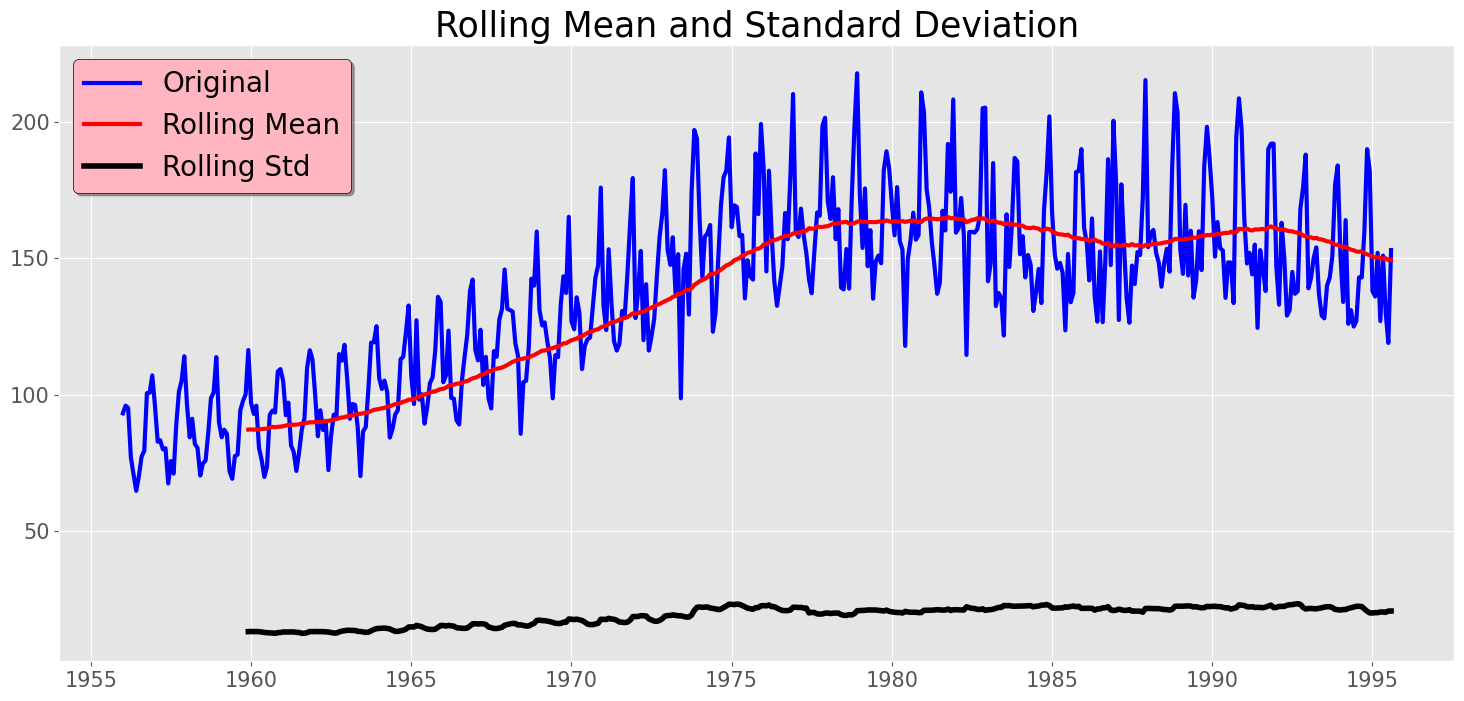

Results of dickey fuller test
Test Statistics                 -2.282661
p-value                          0.177621
No. of lags used                17.000000
Number of observations used    458.000000
critical value (1%)             -3.444709
critical value (5%)             -2.867871
critical value (10%)            -2.570142
dtype: float64


In [89]:
test_stationarity(df_beer_production)

Null Hypothesis = data is staionary
p-value is greater tham 0.05 that null hypothesis is rejected

The following visualization shows beer production over given period of time (in both levels and logartihms). Based on that we can make several observations:

There was a significant growth showing a positive trend in beer production until 1974. After this year, the trend stabilized. In early 80's the trend was negative (slight decrease in beer production). As there are different trends over the time, it indicates non-stationarity of the series.

The beer production is reaching its peak around Christmas (Dec), which also corresponds to Australian summer. After that production is decreasing and reaching its minimum during mid-year holidays. This pattern is repeatable, therefore the series has seasonal component.

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(data["Monthly beer production"],model= "multiplicative",period=30)

<Figure size 2000x1000 with 0 Axes>

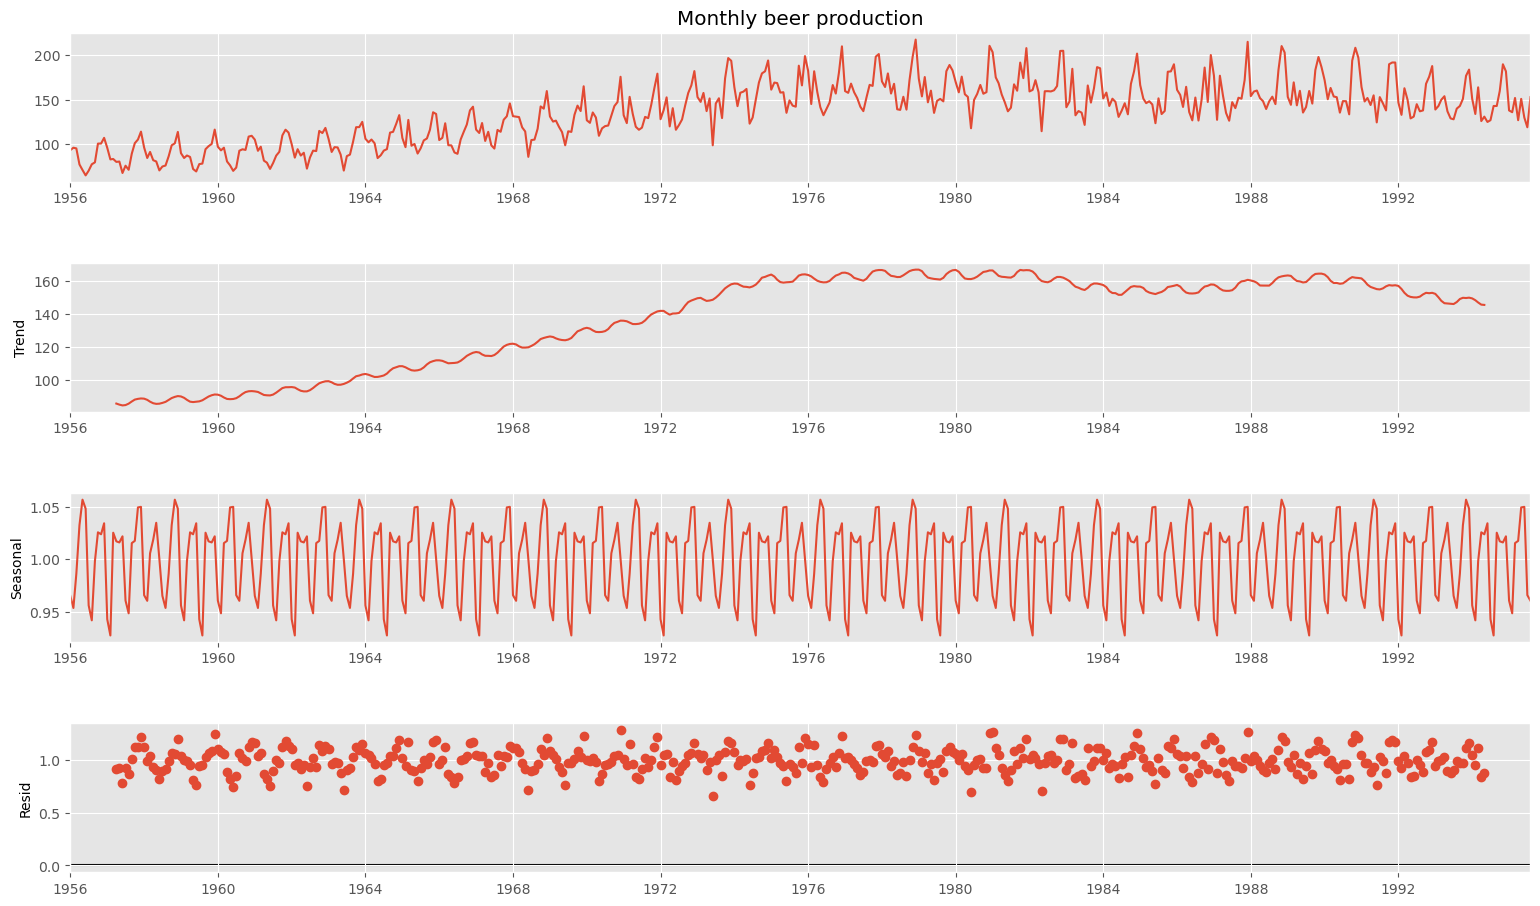

In [94]:
plt.figure(figsize=(20,10))
fig=result.plot()
fig.set_size_inches(17,10)

In [95]:
result.seasonal

Month
1956-01-01    0.965070
1956-02-01    0.953497
1956-03-01    0.986147
1956-04-01    1.032552
1956-05-01    1.056928
                ...   
1995-04-01    1.017575
1995-05-01    1.049529
1995-06-01    1.050085
1995-07-01    0.965732
1995-08-01    0.960322
Name: seasonal, Length: 476, dtype: float64

In [96]:
result.resid

Month
1956-01-01   NaN
1956-02-01   NaN
1956-03-01   NaN
1956-04-01   NaN
1956-05-01   NaN
              ..
1995-04-01   NaN
1995-05-01   NaN
1995-06-01   NaN
1995-07-01   NaN
1995-08-01   NaN
Name: resid, Length: 476, dtype: float64

In [97]:
result.trend

Month
1956-01-01   NaN
1956-02-01   NaN
1956-03-01   NaN
1956-04-01   NaN
1956-05-01   NaN
              ..
1995-04-01   NaN
1995-05-01   NaN
1995-06-01   NaN
1995-07-01   NaN
1995-08-01   NaN
Name: trend, Length: 476, dtype: float64

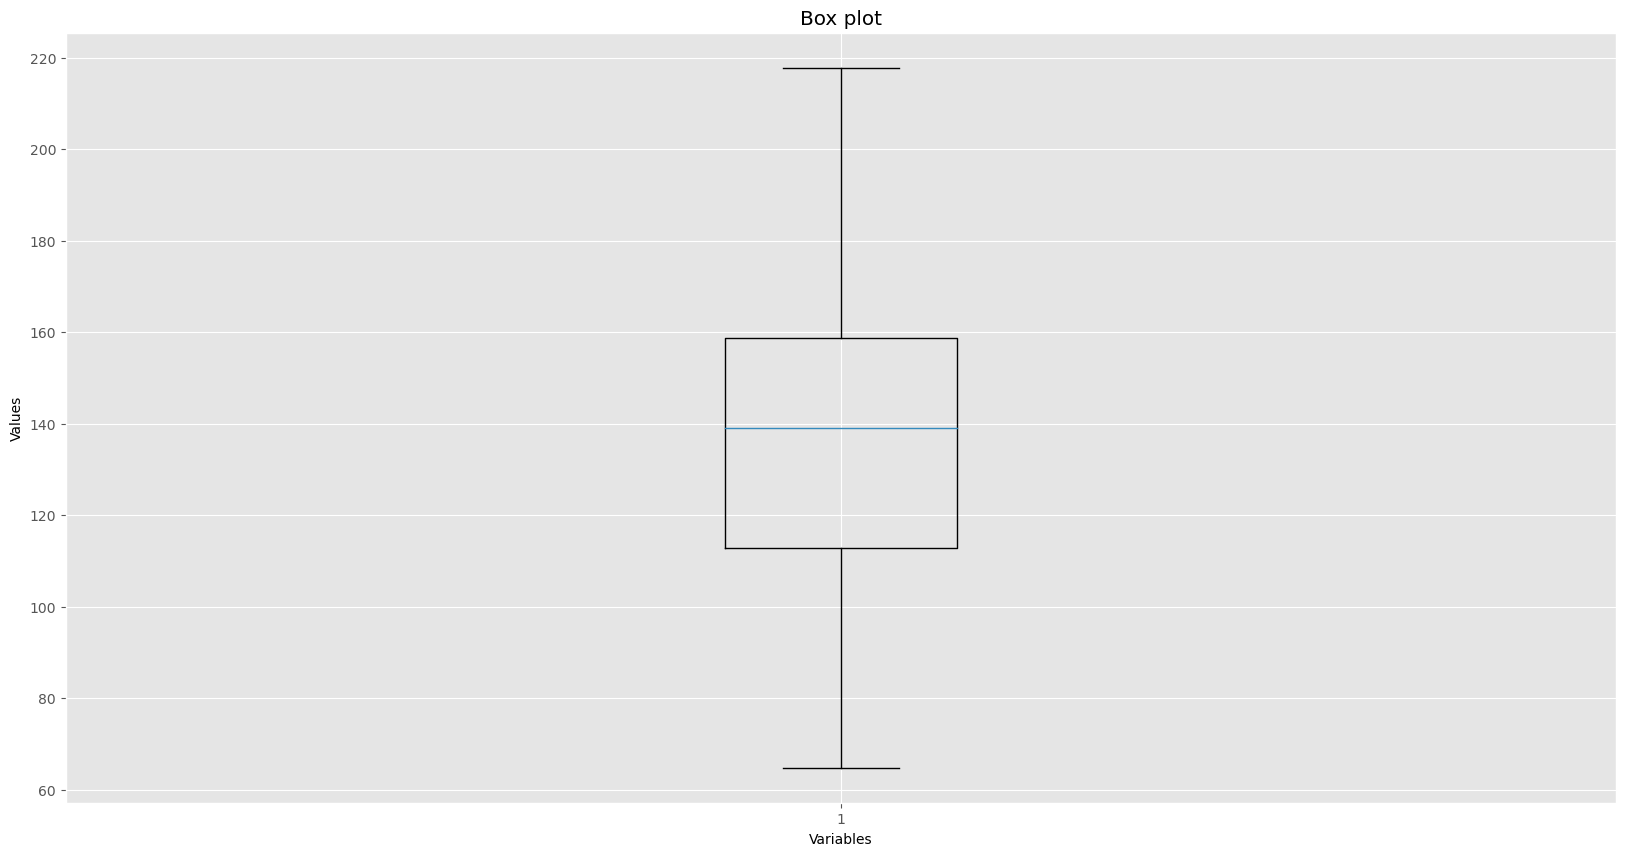

In [101]:
fig, ax = plt.subplots(figsize=(20, 10))
# Plot the box plot
ax.boxplot(data["Monthly beer production"])
# Set the x-axis label
ax.set_xlabel('Variables')
# Set the y-axis label
ax.set_ylabel('Values')
# Set the title
ax.set_title('Box plot')
# Show the plot
plt.show()

There is no outlier

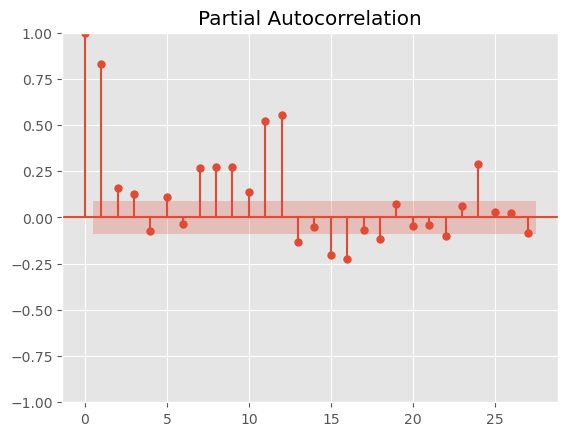

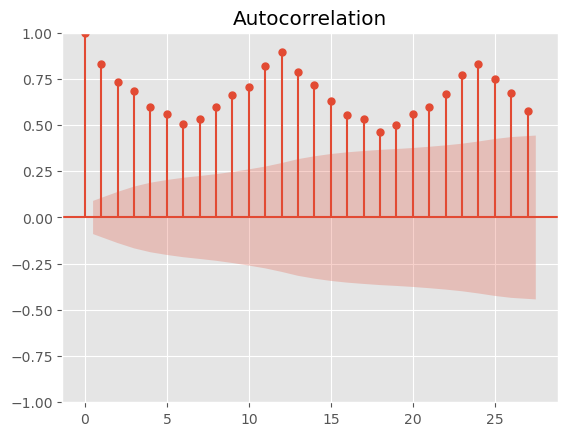

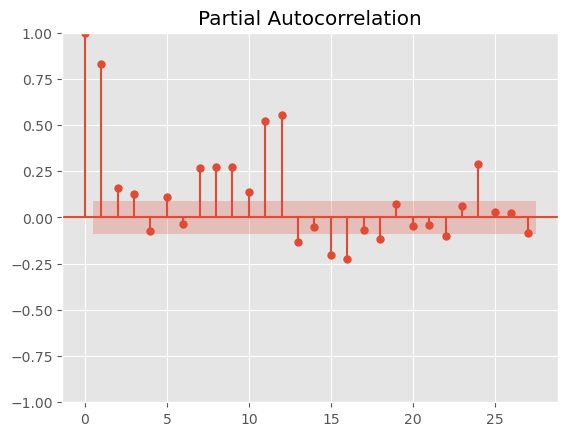

In [102]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(data["Monthly beer production"])
plot_pacf(data["Monthly beer production"])

# Preprocessing of the data

1. fill the miss(here not required)

2. convert data into the stationary time series

3. if necessary then normalize the data(here not required)

4. split the data into train and test

5. clean the data by removing the outlier(here not required)

In [103]:
df_beer_producton=data["Monthly beer production"]

In [105]:
df_beer_producton=df_beer_producton.diff()

In [106]:
df_beer_producton=df_beer_producton.dropna()

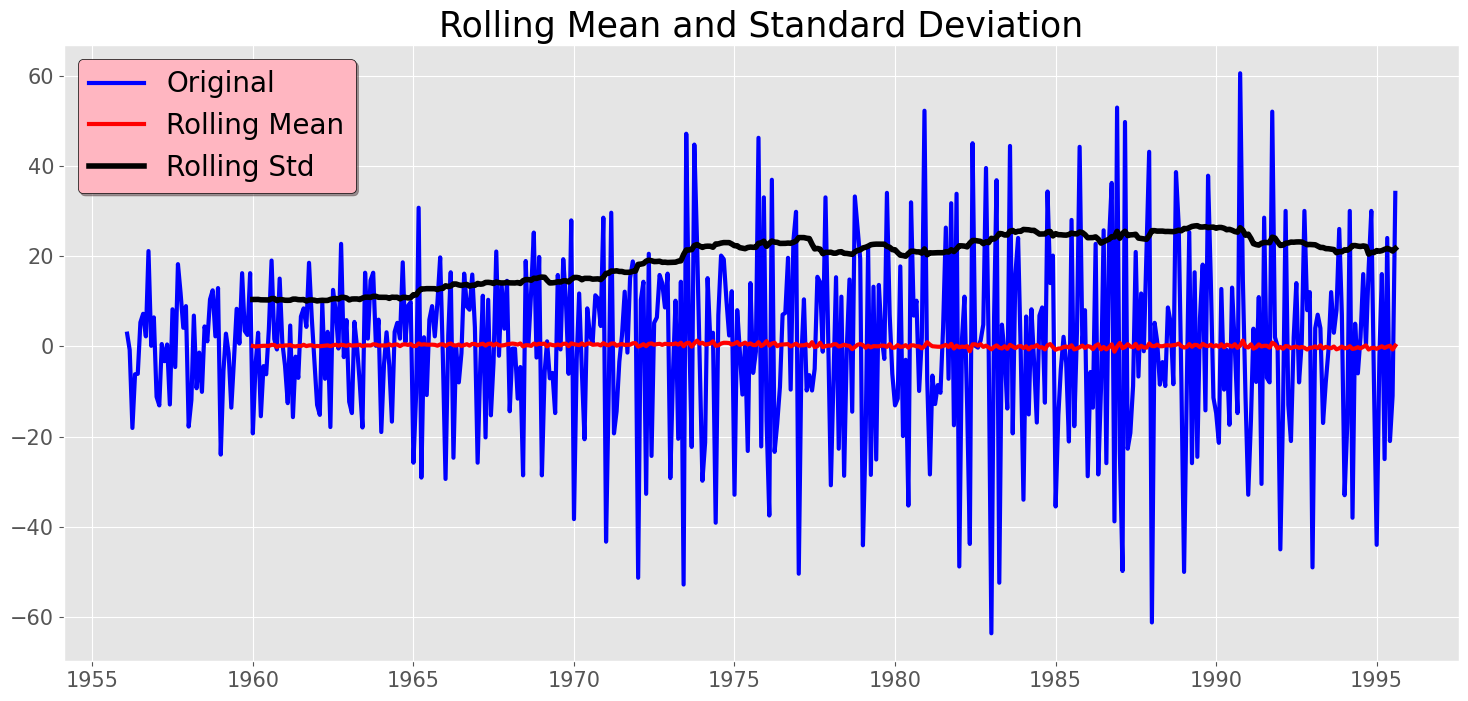

Results of dickey fuller test
Test Statistics                 -4.980664
p-value                          0.000024
No. of lags used                18.000000
Number of observations used    456.000000
critical value (1%)             -3.444772
critical value (5%)             -2.867899
critical value (10%)            -2.570157
dtype: float64


In [107]:
test_stationarity(df_beer_producton)   #checking data is stationary or not

In [108]:
df_beer_producton.diff(2)

Month
1956-02-01     NaN
1956-03-01     NaN
1956-04-01   -20.9
1956-05-01    -5.4
1956-06-01    12.0
              ... 
1995-04-01   -23.0
1995-05-01     8.0
1995-06-01     4.0
1995-07-01   -35.0
1995-08-01    55.0
Name: Monthly beer production, Length: 475, dtype: float64

In [109]:
df_beer_producton.diff(3)

Month
1956-02-01     NaN
1956-03-01     NaN
1956-04-01     NaN
1956-05-01    -9.0
1956-06-01    -5.3
              ... 
1995-04-01    19.0
1995-05-01    26.0
1995-06-01   -37.0
1995-07-01    14.0
1995-08-01    10.0
Name: Monthly beer production, Length: 475, dtype: float64

In [110]:
train_data=df_beer_producton[0:-40]
test_data=df_beer_producton[-40:]

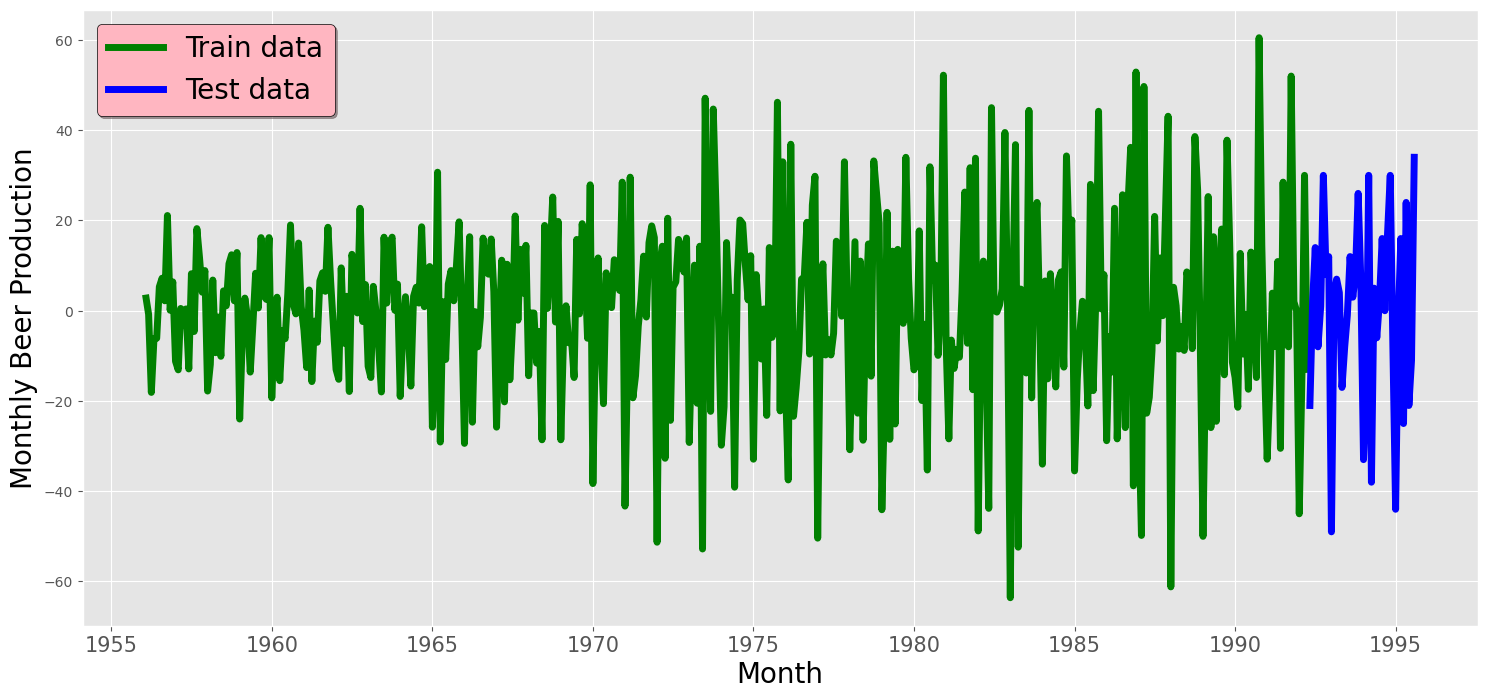

In [111]:
plt.figure(figsize=(18,8))
plt.grid(True)
plt.xlabel('Month', fontsize = 20)
plt.ylabel('Monthly Beer Production', fontsize = 20)
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.plot(train_data, 'green', label='Train data', linewidth = 5)
plt.plot(test_data, 'blue', label='Test data', linewidth = 5)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')

In [112]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

SARIMA and ARIMA model

Based on the exploratory analysis discovering the data are seasonal, Seasonal ARIMA MODEL (Auto Regressive Integrated Moving Average) will be used.

For applying the ARIMA model we need p,q and q parameters:

p is the AR model lags and can be determined from the pacf plot

d is the degree of differencing

q is the size of the moving average window (order)

For applying SARIMA model we need another parameter s:

s is the determination of seasonality

In [113]:
def train_arima_model(X, y, arima_order):
    # prepare training dataset
    # make predictions list
    history = [x for x in X]
    predictions = list()
    for t in range(len(y)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(y[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(y, predictions))
    return rmse

In [115]:
# evaluate different combinations of p, d and q values for an ARIMA model to get the best order for ARIMA Model
def evaluate_models(dataset, test, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = train_arima_model(dataset, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


In [116]:
# evaluate parameters
import warnings
warnings.filterwarnings('ignore')
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(train_data, test_data, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=20.024
ARIMA(0, 0, 1) RMSE=19.571
ARIMA(0, 0, 2) RMSE=18.078
ARIMA(0, 1, 0) RMSE=29.755
ARIMA(0, 1, 1) RMSE=20.024
ARIMA(0, 1, 2) RMSE=19.571
ARIMA(0, 2, 0) RMSE=50.168
ARIMA(0, 2, 1) RMSE=29.788
ARIMA(0, 2, 2) RMSE=20.176
ARIMA(1, 0, 0) RMSE=19.908
ARIMA(1, 0, 1) RMSE=18.182
ARIMA(1, 0, 2) RMSE=19.017
ARIMA(1, 1, 0) RMSE=27.211
ARIMA(1, 1, 1) RMSE=19.906
ARIMA(1, 1, 2) RMSE=19.947
ARIMA(1, 2, 0) RMSE=40.986
ARIMA(1, 2, 1) RMSE=27.237
ARIMA(1, 2, 2) RMSE=19.955
ARIMA(2, 0, 0) RMSE=19.203
ARIMA(2, 0, 1) RMSE=19.448
ARIMA(2, 0, 2) RMSE=17.955
ARIMA(2, 1, 0) RMSE=23.937
ARIMA(2, 1, 1) RMSE=19.205
ARIMA(2, 1, 2) RMSE=19.446
ARIMA(2, 2, 0) RMSE=34.855
ARIMA(2, 2, 1) RMSE=23.962
ARIMA(2, 2, 2) RMSE=19.233
Best ARIMA(2, 0, 2) RMSE=17.955


In [117]:
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
for p in p_values:
        for d in d_values:
            for q in q_values:
                print(p,d,q)

0 0 0
0 0 1
0 0 2
0 1 0
0 1 1
0 1 2
0 2 0
0 2 1
0 2 2
1 0 0
1 0 1
1 0 2
1 1 0
1 1 1
1 1 2
1 2 0
1 2 1
1 2 2
2 0 0
2 0 1
2 0 2
2 1 0
2 1 1
2 1 2
2 2 0
2 2 1
2 2 2


In [120]:
history=[x for x in train_data]
predictions=list()
conf_list=list()
for t in range(len(test_data)):
    model=ARIMA(history,order=(2,0,2))
    model_fit = model.fit()
    fc = model_fit.forecast(alpha = 0.05,order=(2,0,2))
    predictions.append(fc)
    #conf_list.append(conf)
    history.append(test_data[t])
print("RMSE of ARIMA Model:",np.sqrt(mean_squared_error(test_data,predictions)))

RMSE of ARIMA Model: 17.955212516617042


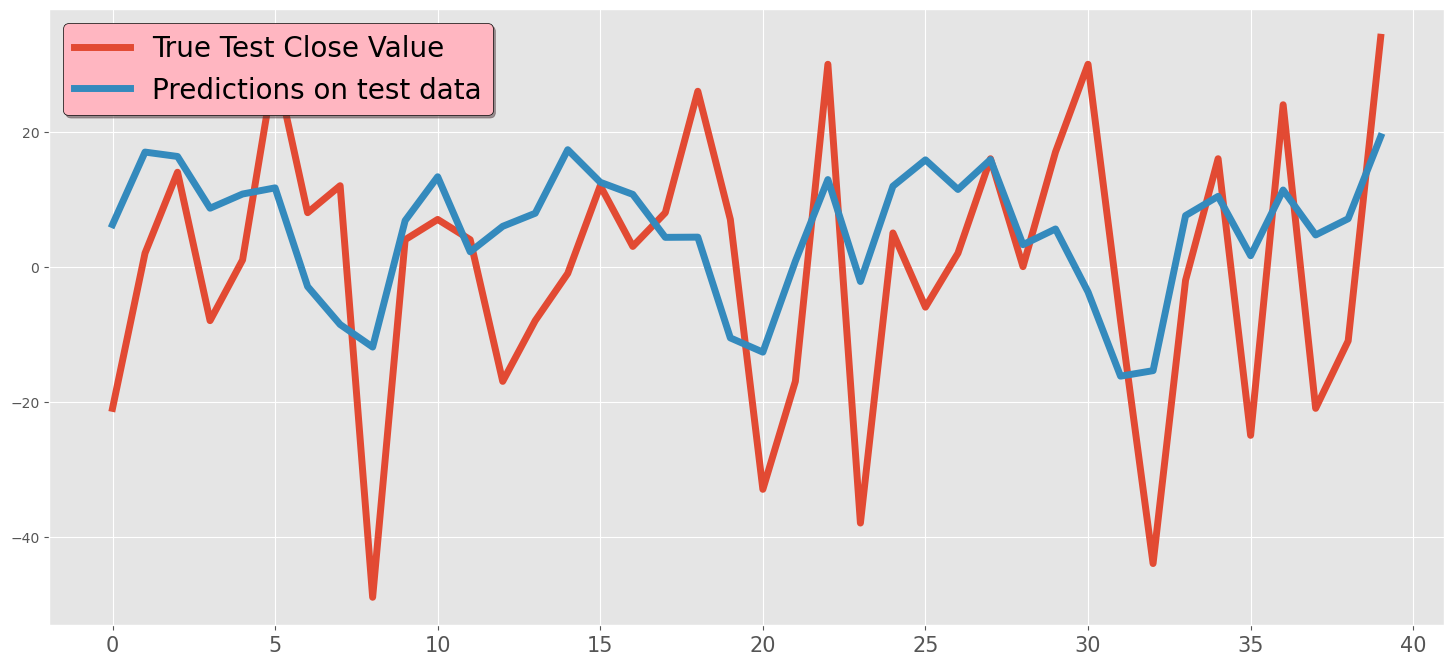

In [121]:
plt.figure(figsize=(18,8))
plt.grid(True)
plt.plot(range(len(test_data)),test_data, label = 'True Test Close Value', linewidth = 5)
plt.plot(range(len(predictions)), predictions, label = 'Predictions on test data', linewidth = 5)
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.show()

build a model with SARIMAX

In [122]:
import statsmodels.api as sm
history=[x for x in train_data]
predictions=list()

for t in range(len(test_data)):
    model=sm.tsa.statespace.SARIMAX(history,order=(2,0,2),seasonal_order=(2,0,2,3))
    model_fit=model.fit()
    fc=model_fit.forecast(alpha=0.05)
    predictions.append(fc)
    history.append(test_data[t])
print("RMSE of SARIMAX Model:",np.sqrt(mean_squared_error(test_data,predictions)))

RMSE of SARIMAX Model: 12.261658577954387


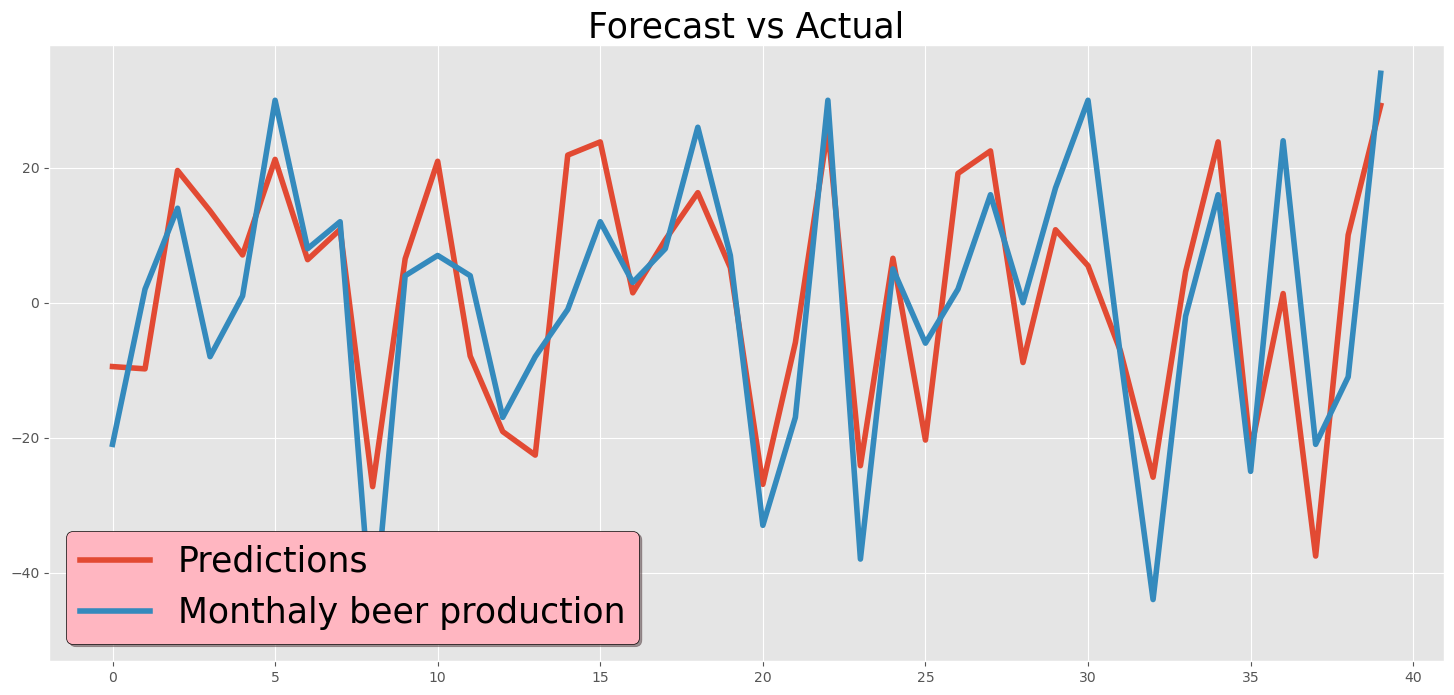

In [124]:
plt.figure(figsize=(18,8))
plt.title('Forecast vs Actual', fontsize = 25)
plt.plot(range(40), predictions, label = 'Predictions', linewidth = 4)
plt.plot(range(40), test_data, label = 'Monthaly beer production', linewidth = 4)
plt.legend(fontsize = 25, shadow=True,facecolor='lightpink',edgecolor = 'k')

In [125]:
model_fit.predict(start=1,end=len(df_beer_production)+365)

array([-1.37951192e+00, -3.73378090e-01,  1.28695554e+01,  1.48966783e+01,
        1.12319870e+01,  1.87773886e+00, -3.04275186e+00,  7.24948295e+00,
       -7.22723222e+00, -2.40252207e+00, -1.19163433e+01, -2.52146438e+00,
        8.15576923e+00, -8.22896280e+00, -5.87314842e+00, -1.05789527e+01,
        8.97118069e+00,  5.26951842e+00,  9.70431110e+00,  4.37532148e+00,
       -5.07015279e+00, -1.50616076e+00, -1.66031582e+01, -1.71420876e+00,
        4.01194000e+00, -1.35672971e+01, -5.68554973e+00, -1.09976824e+01,
        8.39352996e+00,  8.10451348e+00,  8.78473695e+00,  1.00963561e+01,
       -4.81009575e-01,  5.49616329e+00, -1.53664020e+01,  3.75437454e+00,
        3.84912482e+00, -9.72483956e+00, -9.03736352e+00, -4.75535042e+00,
        8.78580929e+00,  4.82027615e+00,  6.81516002e+00,  1.45971617e+00,
        1.75514673e+00,  6.77099541e+00, -1.80833434e+01, -3.08435897e+00,
       -3.82460851e+00, -1.46684165e+01, -2.77212598e+00, -7.25574602e+00,
        1.01862603e+01,  